<a href="https://colab.research.google.com/github/eleonorabertoni/progetto_data_intensive/blob/main/progetto_data_intensive_eleonora_bertoni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Previsione su annullamento di una prenotazione



##Librerie

In [1]:
#librerie base e grafici
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os.path
import seaborn as sns
from matplotlib import rcParams

In [2]:
#scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error
from scipy import stats


#Descrizione del problema
Il dataset utilizzato contiene informazioni relative a prenotazioni fatte per un hotel di città e un resort hotel. Vogliamo trovare un modello che predica se un cliente annullerà una determinata prenotazione. Per un hotel questa informazione può risultare importante per organizzare al meglio cibi e vivande ma anche il personale. 

Il dataset è disponibile cliccando sul [link]("https://www.kaggle.com/jessemostipak/hotel-booking-demand")


##Download del dataset

In [3]:
file_csv_url = "https://raw.githubusercontent.com/eleonorabertoni/progetto_data_intensive/main/hotel_bookings.csv"

booking_data_set = "hotel_bookings.csv"
if not os.path.exists(booking_data_set):
    from urllib.request import urlretrieve
    urlretrieve(file_csv_url, booking_data_set)

In [4]:
#partendo dal file csv salvo il dataset come dataframe 
with open(booking_data_set) as dataFile:
    bookings = pd.read_csv(dataFile, sep=",")

In [5]:
#numero di istanze in totale
bookings.shape

(119390, 32)

In [6]:
#visualizzazione 
bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


##Descrizione delle features

Riportiamo le informazioni sul dataset tratte dalla [fonte](https://www.sciencedirect.com/science/article/pii/S2352340918315191)

1. **`hotel`** l'hotel a cui fa riferimento la prenotazione.

1. **`isCanceled`** valore che indica se la prenotazione è stata cancellata oppure no. Si tratta della variabile da predire. Assume valori 0 e 1.

1. **`leadTime`** numero di giorni passati tra il momento in cui è stata sottomessa la prenotazione e la data di arrivo.

1. **`arrivalDateYear`** anno della data di arrivo.

1. **`arrivalDateMonth`** mese della data di arrivo.

1. **`arrivalDateWeekNumber`** mese della data di arrivo.

1. **`arrivalDateDayOfMonth`** giorno del mese della data di arrivo.

1. **`staysInWeekendNights`** numero di notti di un weekend prenotate.

1. **`staysInWeekNights`** numero di notti non nel weekend prenotate.

1. **`adults`** numero di adulti.

1. **`children`** numero di figli.

1. **`babies`** numero di bambini piccoli.

1. **`Meal`** tipo di pasto prenotato. Undefined/SC se non è stato scelto alcun pasto, BB per bread & breakfast, HB per colazioni e un altro pasto, FB per tutti i pasti.

1. **`country`** paese di origine

1. **`marketSegment`** il segmento di mercato di designazione.

1. **`distributionChannel`** il canale di distribuzione delle prenotazioni.

1. **`isRepeatedGuest`** indica se la prenotazione è stata fatta con un nominativo usato per prenotazioni precedenti.

1. **`previousCancellations`** numero di prenotazioni precedenti che sono state cancellate in precedenza dal cliente.

1. **`previousBookingsNotCanceled`** numero di prenotazioni precedenti che non sono state cancellate in precedenza dal cliente.

1. **`reservedRoomType`** codice del tipo di stanza riservata.

1. **`assignedRoomType`** tipo della stanza assegnata alla prenotazione. In alcuni casi può essere diverso dal tipo di stanza riservato.

1. **`bookingChanges`** numero di cambiamenti fatti alla prenotazione dal momento in cui viene sottomessa a quando viene fatto check-in/annullamento.

1. **`depositType`** indica se un cliente ha fatto il deposito per garantire la prenotazione: vale no deposit se non è stato fatto alcun deposito, non refund se è stato fatto un deposito del valore del totale, refundable se è stato fatto un deposito parziale.

1. **`agent`** ID dell'agenzia di viaggi che ha fatto la prenotazione.

1. **`company`** ID della compagnia o entità che ha fatto/pagato la prenotazione.

1. **`daysInWaitingList`** numero di giorni durante i quali la prenotazione è rimasta nella lista di attesa prima di venire confermata al cliente.

1. **`customerType`** tipo di prenotazione. Si assumono 4 tipi di prenotazione: contratto, group, transient se non rientra nei primi due e non è associata ad altre prenotazioni transitorie, transient-party se è associata a una prenotazione transitoria.

1. **`adr`** average daily rate ovvero la tariffa media giornaliera incassata per le camere al netto di tasse, sconti e pasti.

1. **`requiredCardParkingSpaces`** numero di posti parcheggio richiesti dal cliente.

1. **`totalOfSpecialRequests`** numero di richieste speciali fatte dal cliente.

1. **`reservationStatus`** ultimo stato della prenotazione: può essere canceled, check-out, no-show

1. **`reservationStatusDate`** data dell'ultimo aggiornamento dello status.


In [7]:
bookings.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

## Eliminazione variabili non rilevanti

L'obiettivo è quello di utilizzare il dataset per addestrare un modello in grado di predire se un cliente annullerà la prenotazione fatta. In particolare dovrà predire il valore della variabile binaria discreta **is_canceled**: 1 in caso di cancellazione, 0 in caso contrario.

Dal momento che il dataset raccoglie informazioni riguardanti due hotel decidiamo di focalizzarci sull'hotel di città. Dobbiamo quindi lavorare solo sulle righe con dati riguardanti quell'hotel e rimuovere la colonna **hotel**.



In [8]:
#verifico che siano gli unici hotel di cui sono stati inseriti i dati
bookings["hotel"].value_counts()

City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64

In [9]:
#mantengo solo le righe del City Hotel
b = bookings["hotel"] == "City Hotel"
bookings = bookings[b]

L'obiettivo è quello di addestrare un modello generale, in grado di gestire casi di nuovi clienti e che si basi quindi principalmente sulle informazioni relative alle prenotazioni. Pertanto le variabili **is_repeated_guest**, **previous_cancellations** e **previous_bookings_not_canceled** saranno rimosse.

Anche **arrival_date_year** non presenta un'informazione utile per la predizione. Può essere però utile per la visualizzazione di alcune variabili e sarà rimossa in un secondo momento.

Per via della natura della variabile da predire non possiamo utilizzare le variabili **reserved_room_type** e **booking_changes** in quanto la prima è nota solo in un momento successivo alla prenotazione e entrambe sono soggette a cambiamenti.

La variabile **country** presenta 166 classi alcune poco popolate. Questo potrebbe influenzare in modo negativo la predizione e pertanto verrà rimossa.

In [10]:
print(bookings["country"].isna().sum())
print(len(bookings["country"].unique()))
print(bookings["country"].value_counts())

24
167
PRT    30960
FRA     8804
DEU     6084
GBR     5315
ESP     4611
       ...  
NCL        1
KIR        1
AIA        1
UGA        1
MRT        1
Name: country, Length: 166, dtype: int64


Infine la variabile **reservation_status** non può essere utilizzata perchè se assume valore diverso da "No-show" (che non fornisce informazioni) otteniamo il valore di **is_canceled** ovvero della variabile da predire. Di conseguenza non possiamo utilizzare nemmeno **reservation_status_date** che fa riferimento a **reservation_status**

In [11]:
#scarto le colonne hotel, booking_changes, reservation_status e reservation_status_date
bookings.drop(columns=["hotel", "previous_cancellations", "previous_bookings_not_canceled", "reserved_room_type", "booking_changes", "country", "is_repeated_guest", "reservation_status", "reservation_status_date"], inplace=True)

In [12]:
#verifica e visualizzazione shape 
print(bookings.shape)

(79330, 23)


##Gestione valori nulli

Riveliamo la presenza di valori nulli

In [13]:
bookings.isna().sum()

is_canceled                        0
lead_time                          0
arrival_date_year                  0
arrival_date_month                 0
arrival_date_week_number           0
arrival_date_day_of_month          0
stays_in_weekend_nights            0
stays_in_week_nights               0
adults                             0
children                           4
babies                             0
meal                               0
market_segment                     0
distribution_channel               0
assigned_room_type                 0
deposit_type                       0
agent                           8131
company                        75641
days_in_waiting_list               0
customer_type                      0
adr                                0
required_car_parking_spaces        0
total_of_special_requests          0
dtype: int64

Posso supporre che la varibile **children** valga 0 se non inserita.

In [14]:
bookings["children"].fillna(0, inplace=True)

Rimuoviamo le righe in cui non siamo a conoscenza di country

Notiamo che le colonne **agent** e **company** presentano molti valori mancanti e verranno quindi rimosse. 

Nel caso di **agent** la scelta è stata effettuata considerando che per la natura della variabile questa si divide in numerose classi e alcune poco popolate. Introdurre una classe 'unknown' avrebbe avuto un forte impatto.

In [15]:
#numero di classi diverse per agent
print(len(bookings["agent"].unique()))
bookings.drop(columns=["agent", "company"], inplace=True)

224


In [16]:
bookings.isna().sum()

is_canceled                    0
lead_time                      0
arrival_date_year              0
arrival_date_month             0
arrival_date_week_number       0
arrival_date_day_of_month      0
stays_in_weekend_nights        0
stays_in_week_nights           0
adults                         0
children                       0
babies                         0
meal                           0
market_segment                 0
distribution_channel           0
assigned_room_type             0
deposit_type                   0
days_in_waiting_list           0
customer_type                  0
adr                            0
required_car_parking_spaces    0
total_of_special_requests      0
dtype: int64

##Data cleaning

Il numero di persone in totale non può essere minore o uguale di zero 

In [17]:
#controllo
guests_number = bookings["adults"] + bookings["children"] + bookings["babies"]
(guests_number <= 0).sum()

167

In [18]:
#eliminazione
bookings = bookings[guests_number > 0].copy()

In [19]:
#verifica
guests_number = bookings["adults"] + bookings["children"] + bookings["babies"]
(guests_number <= 0).sum()

0

Alcune variabili categoriche presentano classi con pochissimi valori. Pertanto si decide di eliminare questi casi con pochi campioni per evitare che influenzino negativamente il modello ottenuto.

In [20]:
def remove_classes_threshold(column, thresh):
  #distribuzione
  classes = bookings[column].value_counts()
  
  #le righe delle classi che superano la soglia sono mantenute
  classes_ok = np.isin(bookings[column], classes[classes.array > thresh].index)
  
  #modifico il mio dataset
  return bookings[classes_ok]

In [21]:
t = 500
bookings = remove_classes_threshold("assigned_room_type", t)
bookings = remove_classes_threshold("customer_type", t)
bookings = remove_classes_threshold("distribution_channel", t)
bookings = remove_classes_threshold("market_segment", t)
bookings = remove_classes_threshold("meal", t)

In [22]:
b = bookings.drop(columns="arrival_date_year")

In [23]:
custom_dtypes = {
    "arrival_date_month": "category",
    "assigned_room_type": "category",
    "customer_type": "category",
    "deposit_type": "category",
    "distribution_channel": "category",
    "market_segment": "category",
    "meal": "category",
}
b = b.astype(custom_dtypes)

# Visualizzazione delle features

In [24]:
#Funzione per osservare la distribuzione di una variabile categorica.
#Viene mostrato un grafo a torta con relativa percentuale
def print_and_show_distribution_cat(c, labels=None):
     print(bookings[c].value_counts())
     print(len(bookings[c].unique()))
     bookings[c].value_counts().plot.pie(autopct='%1.1f%%',  labels=bookings[c].value_counts().index, figsize=(7,7))

Visualizziamo la distribuzione della variabile discreta da predire **is_canceled**

0    45161
1    32896
Name: is_canceled, dtype: int64
2


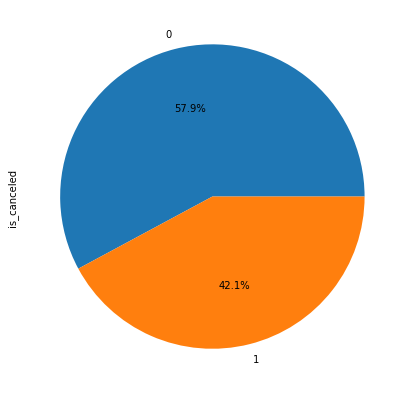

In [25]:
print_and_show_distribution_cat("is_canceled")

In [26]:
bookings.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78057 entries, 40060 to 119389
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   is_canceled                  78057 non-null  int64  
 1   lead_time                    78057 non-null  int64  
 2   arrival_date_year            78057 non-null  int64  
 3   arrival_date_month           78057 non-null  object 
 4   arrival_date_week_number     78057 non-null  int64  
 5   arrival_date_day_of_month    78057 non-null  int64  
 6   stays_in_weekend_nights      78057 non-null  int64  
 7   stays_in_week_nights         78057 non-null  int64  
 8   adults                       78057 non-null  int64  
 9   children                     78057 non-null  float64
 10  babies                       78057 non-null  int64  
 11  meal                         78057 non-null  object 
 12  market_segment               78057 non-null  object 
 13  distributio

In [27]:
def print_and_show_distribution_cat(c, labels=None):
     print(bookings[c].value_counts())
     print(len(bookings[c].unique()))
     bookings[c].value_counts().plot.pie(autopct='%1.1f%%',  labels=bookings[c].value_counts().index, figsize=(7,7))

## Visualizzazione variabili numeriche

Visualizziamo la correlazione delle variabili numeriche focalizzandoci sul legame con **is_canceled**. Notiamo che non vi sono correlazioni alte tra le features.

In [28]:
corr = b.corr()
a = corr["is_canceled"].sort_values(ascending=False)[1:]
print(a)

lead_time                      0.307355
days_in_waiting_list           0.060412
stays_in_week_nights           0.049528
adults                         0.046455
arrival_date_week_number       0.001523
arrival_date_day_of_month     -0.004416
stays_in_weekend_nights       -0.007813
adr                           -0.017231
children                      -0.028176
babies                        -0.030583
required_car_parking_spaces   -0.134267
total_of_special_requests     -0.297302
Name: is_canceled, dtype: float64


In [29]:
b.describe()

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,78057.000000,78057.000000,78057.000000,78057.000000,78057.000000,78057.000000,78057.000000,78057.000000,78057.000000,78057.000000,78057.000000,78057.000000,78057.000000
mean,0.421436,110.860064,27.147584,15.789628,0.795137,2.186120,1.860294,0.092202,0.004945,3.271929,105.631791,0.024380,0.548240
std,0.493792,111.117966,13.376196,8.728694,0.876064,1.422425,0.499712,0.373919,0.084557,21.019806,43.354050,0.154971,0.781471
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,24.000000,17.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,79.200000,0.000000,0.000000
50%,0.000000,75.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000
75%,1.000000,164.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,629.000000,53.000000,31.000000,10.000000,25.000000,4.000000,3.000000,10.000000,391.000000,5400.000000,3.000000,5.000000


Utilizzando il metodo describe rileviamo la media, il valore massimo e il valore minimo, la variazione standard e i percentili di ogni features numerica.

2016    37589
2017    27020
2015    13448
Name: arrival_date_year, dtype: int64


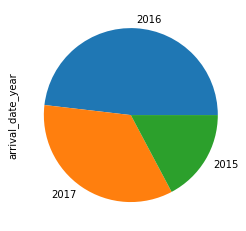

In [30]:
bookings['arrival_date_year'].value_counts().plot.pie();
print(bookings['arrival_date_year'].value_counts())

Come riportato alla [fonte](https://www.sciencedirect.com/science/article/pii/S2352340918315191) i dati sono stati raccolti a partire dal 1 luglio 2015 fino al 31 agosto 2017. Questo ha impatto sul numero di prenotazioni di cui sono salvati i dati per ciascun.

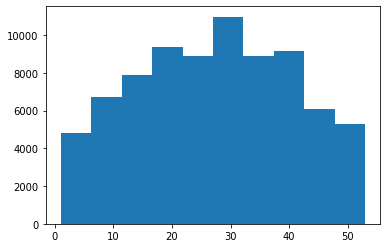

In [31]:
plt.hist(bookings['arrival_date_week_number']);

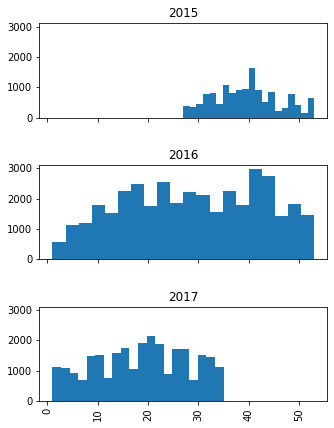

In [32]:
bookings['arrival_date_week_number'].hist(by=bookings['arrival_date_year'], layout=(3,1), figsize=(5,7), sharex=True, sharey = True, bins=20);

Inizialmente possiamo vedere come vi siano meno prenotazioni nelle prime e nelle ultime settimane dell'anno. Questo potrebbe essere dovuto dal periodo durante il quale sono stati raccolti i dati piuttosto che dall'assenza di prenotazioni. 

In [33]:
bookings = b.copy()

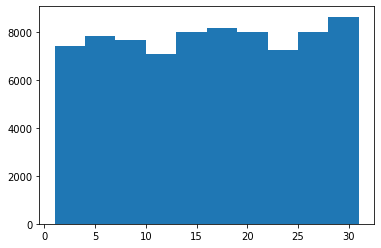

In [34]:
plt.hist(bookings['arrival_date_day_of_month']);

Questo dato, come ci si poteva aspettare, risulta equidistribuito e possiamo considerarne la rimozione considerando il fatto che abbiamo a disposizione altre variabili che danno informazioni riguardo il periodo per cui è fatta la prenotazione.

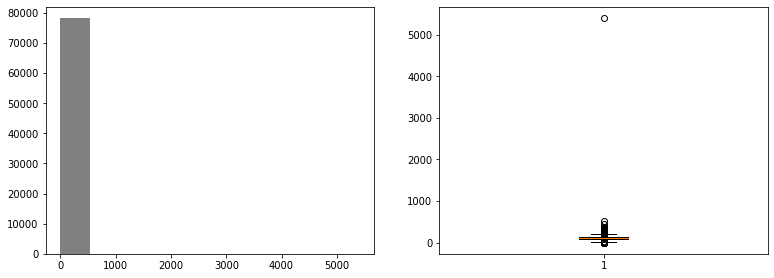

In [35]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.hist(bookings["adr"], color="gray")

plt.subplot(2, 3, 2)
plt.boxplot(bookings['adr']);

Possiamo notare che i prezzi per giornata sono compresi tra circa 0 e 500 e che esiste solo un caso isolato di prezzo molto alto oltre i 5000. Questo valore rappresenta un outliers e pertanto verrà rimosso.

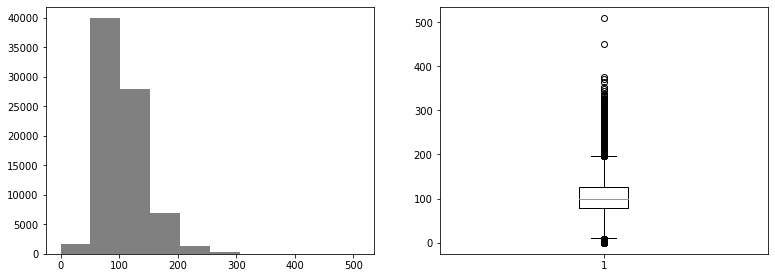

In [36]:
bookings = bookings[bookings["adr"] < 5000]
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.hist(bookings["adr"], color="gray")

plt.subplot(2, 3, 2)
plt.boxplot(bookings['adr']);

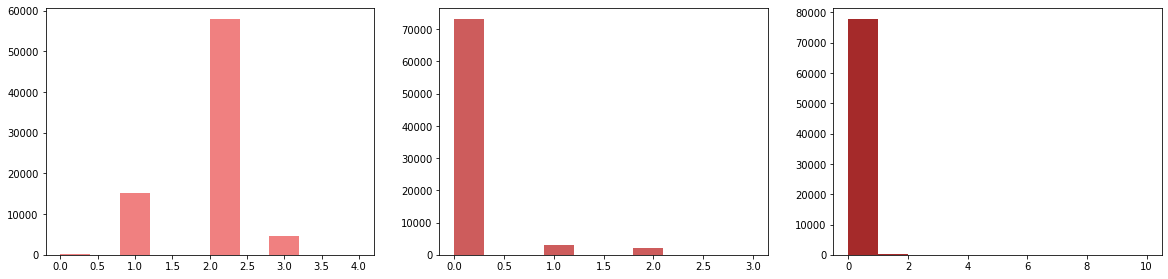

In [37]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.hist(bookings['adults'], color="lightcoral");
plt.subplot(2, 3, 2)
plt.hist(bookings['children'], color="indianred");
plt.subplot(2, 3, 3)
plt.hist(bookings['babies'], color="brown");

Osserviamo che molto spesso il numero di adulti che effettuano la prenotazione è 2 mentre visualizzando le variabili **children** e **babies** notiamo che sono più rari i casi in cui supera lo zero.

74623


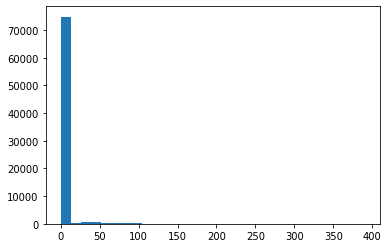

In [38]:
plt.hist(bookings['days_in_waiting_list'], bins=30);
print((bookings['days_in_waiting_list'] == 0).sum())

Risulta chiaro che siano molto rari i casi in cui **days_in_waiting_list** assume valori maggiori di zero e questo significa che le richieste vengono confermate entro il primo giorno.

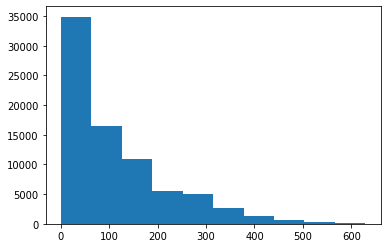

In [39]:
plt.hist(bookings['lead_time']);

Prendendo in esame **lead_time** abbiamo che il massimo valore è 629 ma dal momento che la media vale circa 110 possiamo affermare che sia molto raro. Anche ragionando sul significato della variabile appare chiaro che sia molto difficile che una prenotazione sia fatta con quasi due anni di anticipo.

1896


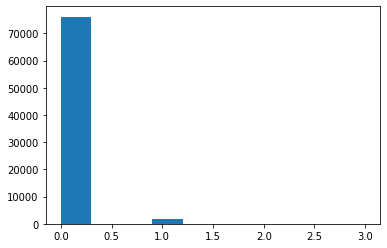

In [40]:
plt.hist(bookings['required_car_parking_spaces']);

#assume valore 0 nella maggior parte dei casi
print((bookings['required_car_parking_spaces'] > 0).sum())

Nell'hotel la maggior parte delle prenotazioni non richiede un posto per parcheggiare.

count    78056.000000
mean         2.981283
std          1.808221
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         34.000000
dtype: float64


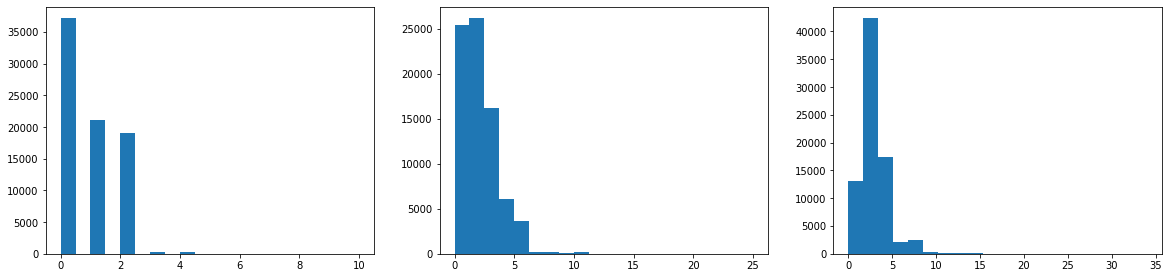

In [41]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.hist(bookings['stays_in_weekend_nights'], bins=20);
plt.subplot(2, 3, 2)
plt.hist(bookings['stays_in_week_nights'], bins=20);
plt.subplot(2, 3, 3)
total_nights = bookings['stays_in_week_nights'] + bookings['stays_in_weekend_nights']
print(total_nights.describe())
plt.hist(total_nights, bins=20);

Si osserva che i media le prenotazioni riguardano 3 notti. Ci sono casi rarissimi di vacanze molto più lunghe.

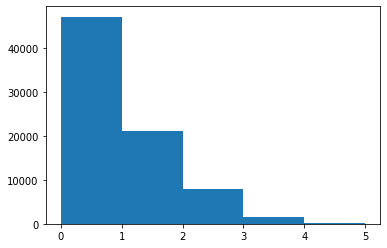

In [42]:
plt.hist(bookings['total_of_special_requests'], bins=5);

Il numero di richieste speciali assume valori all'interno del range 0-5. Sono più frequenti i casi in cui sono fatte 0-1 richieste per prenotazione.

##Visualizzazione variabili categoriche

In questa sezione prendiamo in esame le variabili categoriche: osserveremo il numero di classi considerate da ciascuna variabile e la frequenza con cui esse appaiono all'interno del campione.

August       8881
May          8094
July         8015
June         7779
October      7430
April        7382
September    7304
March        6347
February     4888
November     4196
December     4061
January      3679
Name: arrival_date_month, dtype: int64
12


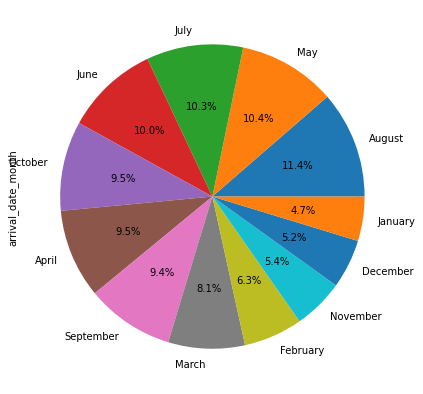

In [43]:
print_and_show_distribution_cat("arrival_date_month")

Il mese in cui si sono registrate più prenotazioni è Agosto. Il mese con minor numero di prenotazioni è invece Gennaio. Si osserva che la distribuzione ricopre tutti i 12 mesi ed è piuttosto equilibrata  e ciò è comprensibile per un hotel di città e quindi meta per il turismo per tutto l'anno.

A    56508
D    14767
E     2106
F     2009
B     1980
G      686
Name: assigned_room_type, dtype: int64
6


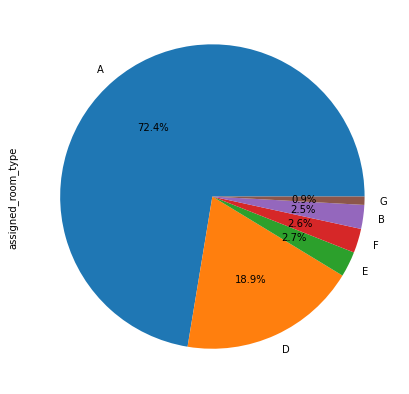

In [44]:
print_and_show_distribution_cat("assigned_room_type")

Prevalgono le stanze di tipo A e B. Risultano meno frequenti le stanze di tipo D, E, F, B. Quasi inutilizzate le altre.

Transient          58587
Transient-Party    17177
Contract            2292
Name: customer_type, dtype: int64
3


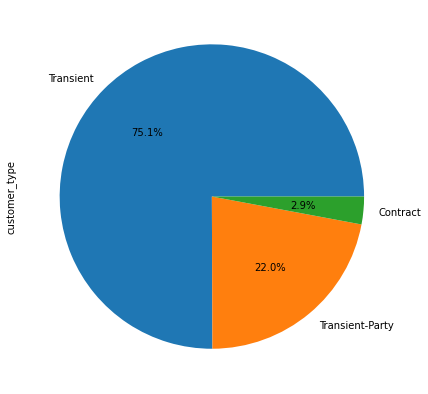

In [45]:
print_and_show_distribution_cat("customer_type")

**Transient** si presenta come la tipologia prevalente.

No Deposit    65170
Non Refund    12866
Refundable       20
Name: deposit_type, dtype: int64
3


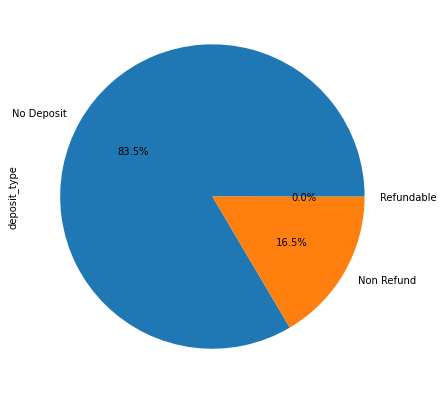

In [46]:
print_and_show_distribution_cat("deposit_type")

**Deposit** si presenta come la tipologia prevalente.

TA/TO        68292
Direct        6631
Corporate     3133
Name: distribution_channel, dtype: int64
3


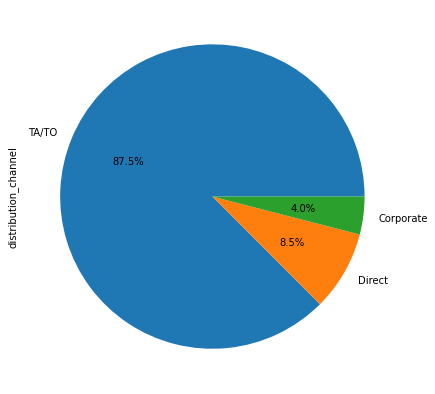

In [47]:
print_and_show_distribution_cat("distribution_channel")

**TA/TO** è prevalente e ciò significa che le prenotazioni vengono fatte principalmente grazie a un agente di viaggi o a un organizzatore (tour operator).

Online TA        38265
Offline TA/TO    16480
Groups           13890
Direct            5964
Corporate         2947
Complementary      510
Name: market_segment, dtype: int64
6


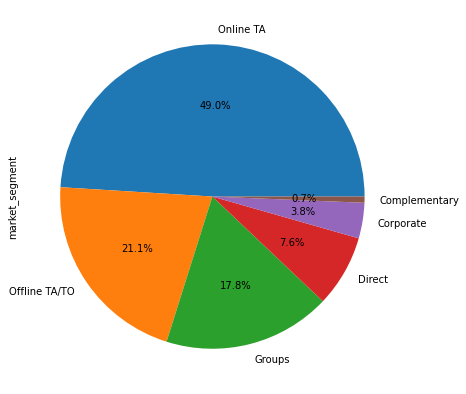

In [48]:
print_and_show_distribution_cat("market_segment")

**Market segment** dovrebbe mostrare i motivi che portano i clienti a fermarsi nell'hotel. Notiamo però che vi è un legame con **distribution channel**.

BB    61391
SC    10286
HB     6379
Name: meal, dtype: int64
3


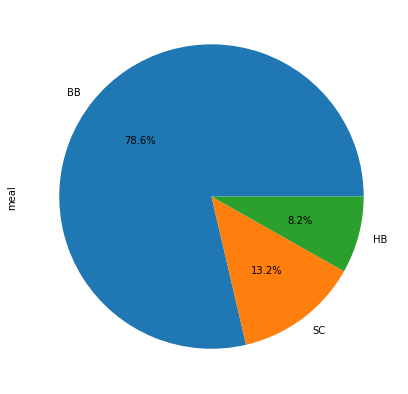

In [49]:
print_and_show_distribution_cat("meal")

La maggior parte dei clienti sceglie l'opzione bed & breakfast.

##Correlazione tra features

Considerando che **lead_time** rappresenta il numero di giorni trascorsi tra la data della prenotazione e la data di arrivo si può ipotizzare che prenotazioni fatte con grande anticipo possano far sì che imprevisti non considerati dai clienti portino alla cancellazione della prenotazione.

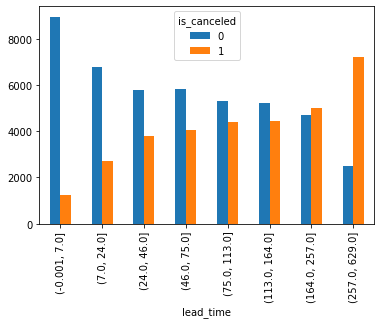

In [50]:
usd_over_status = bookings[["is_canceled", "lead_time"]].copy()
usd_over_status.groupby([pd.qcut(usd_over_status["lead_time"], q=8), "is_canceled"]).size().unstack("is_canceled").plot.bar();

Dalla distribuzione notiamo che il numero di prenotazioni cancellate cresce ma
anche per valori piuttosto alti rimane comunque più alto il numero di prenotazioni che hanno avuto successo. Notiamo però che quando il **lead time**
è molto elevato prevale il numero di cancellazioni. 

Sapendo che **deposit_type** indica se è stata effettuato o meno un pagamento possiamo pensare che chi lo ha effettuato non cancellerà la prenotazione.

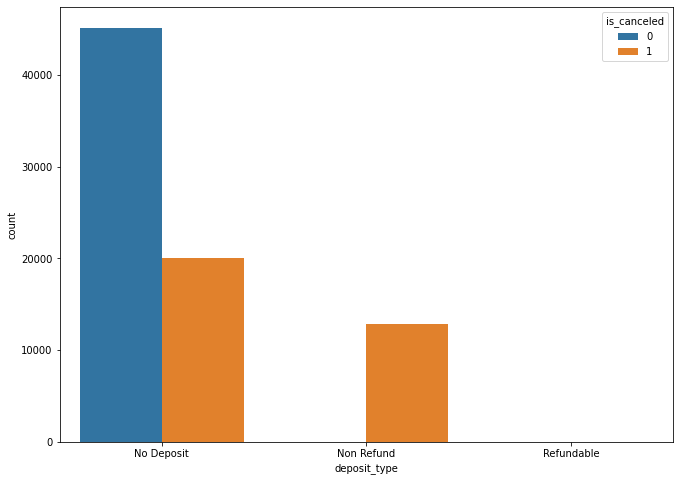

In [51]:
rcParams['figure.figsize'] = 11, 8
sns.countplot(x='deposit_type', hue='is_canceled', data = bookings);

Notiamo che si verifica un'anomalia. Infatti in quasi tutti i casi si verifica il contraio. Questo risulta molto strano pertanto si potrebbe pensare di rimuovere questa variabile.

Si può pensare che all'aumentare delle richieste aumenti il numero di ritiri. Ma possiamo osservare dalla distribuzione seguente che non è così.

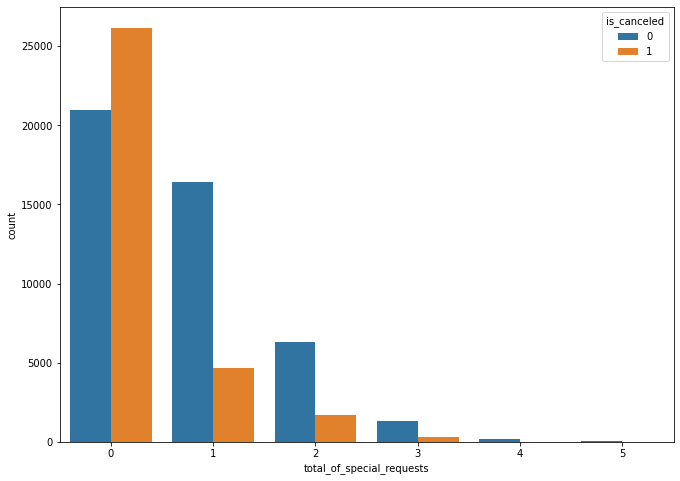

In [52]:
rcParams['figure.figsize'] = 11, 8
sns.countplot(x='total_of_special_requests', hue='is_canceled', data = bookings);

Infine possiamo dire che **arrival_date_month** e **arrival_date_week_number** indichino intrinsecamente un'informazione simile e possiamo quindi scegliere di lavorare con una sola delle due variabili.

# Riepilogo delle features scelte

In [53]:
bookings.head()

,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,assigned_room_type,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
40060,0,6,July,27,1,0,2,1,0.0,0,HB,Offline TA/TO,TA/TO,A,No Deposit,0,Transient,0.0,0,0
40061,1,88,July,27,1,0,4,2,0.0,0,BB,Online TA,TA/TO,A,No Deposit,0,Transient,76.5,0,1
40062,1,65,July,27,1,0,4,1,0.0,0,BB,Online TA,TA/TO,A,No Deposit,0,Transient,68.0,0,1
40063,1,92,July,27,1,2,4,2,0.0,0,BB,Online TA,TA/TO,A,No Deposit,0,Transient,76.5,0,2
40064,1,100,July,27,2,0,2,2,0.0,0,BB,Online TA,TA/TO,A,No Deposit,0,Transient,76.5,0,1


In [54]:
cat_var = ["assigned_room_type",
           "customer_type",
           "distribution_channel",
           "market_segment",
           "meal",
           ]

In [55]:
num_var = ["adr",
           "adults",
           "arrival_date_week_number",
           "babies",
           "children",
           "days_in_waiting_list",
           "lead_time",
           "required_car_parking_spaces",
           "stays_in_week_nights",
           "stays_in_weekend_nights",
           "total_of_special_requests"
           ]

In [56]:
bookings.drop(columns=["arrival_date_day_of_month", "arrival_date_month", "deposit_type"], inplace=True)

In [57]:
bookings.head()

,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,assigned_room_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
40060,0,6,27,0,2,1,0.0,0,HB,Offline TA/TO,TA/TO,A,0,Transient,0.0,0,0
40061,1,88,27,0,4,2,0.0,0,BB,Online TA,TA/TO,A,0,Transient,76.5,0,1
40062,1,65,27,0,4,1,0.0,0,BB,Online TA,TA/TO,A,0,Transient,68.0,0,1
40063,1,92,27,2,4,2,0.0,0,BB,Online TA,TA/TO,A,0,Transient,76.5,0,2
40064,1,100,27,0,2,2,0.0,0,BB,Online TA,TA/TO,A,0,Transient,76.5,0,1


#Modellazione

##Preparazione dati

Utilizziamo il metodo **get_dummies** per poter lavorare anche con le variabili categoriche

In [58]:
bookings.shape

(78056, 17)

In [59]:
bookings = pd.get_dummies(bookings, columns=cat_var, prefix=cat_var)

In [60]:
bookings.head()

,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,assigned_room_type_A,assigned_room_type_B,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,customer_type_Contract,customer_type_Transient,customer_type_Transient-Party,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_TA/TO,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,meal_BB,meal_HB,meal_SC
40060,0,6,27,0,2,1,0.0,0,0,0.0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0
40061,1,88,27,0,4,2,0.0,0,0,76.5,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0
40062,1,65,27,0,4,1,0.0,0,0,68.0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0
40063,1,92,27,2,4,2,0.0,0,0,76.5,0,2,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0
40064,1,100,27,0,2,2,0.0,0,0,76.5,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0


In [61]:
bookings.shape

(78056, 33)

##Suddivisione del dataset

Per accelerare i tempi di addestramento si procede a lavorare su un campione del dataset di 15.000 righe e prendendo metà campioni per ciascuna delle due classi.

In [62]:
#inizializzazione del sample
n = 15_000
sample_canceled = bookings[bookings['is_canceled'] == 1].sample(n//2, random_state=42)
sample_not_canceled = bookings[bookings['is_canceled'] == 0].sample(n//2, random_state=42)
sample = sample_canceled.append(sample_not_canceled)

X = sample.copy().drop('is_canceled', axis=1)
y = sample['is_canceled']

y.value_counts()

1    7500
0    7500
Name: is_canceled, dtype: int64

In [63]:
#split in train e validation set
X_train, X_val, y_train, y_val = train_test_split(X, y.values.ravel(), test_size=0.3, random_state=42, stratify=y.values)

Si utilizza la stratified K fold validation perchè risulta particolarmente utile in un problema di classificazione in quanto aiuta a mantenere la stessa distribuzione all'interno dei diversi fold.

In [64]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)

In [65]:
#Inizializzazione del dizionario che conterra per ciascun modello i valori di
#accuracy, precision, recall e f1-score
models = {}

##Perceptron

In [66]:
#modello
model = Pipeline([
    ('std', StandardScaler()),
    ('perceptron', Perceptron(max_iter=8000, n_jobs=-1, early_stopping=True))
])

#griglia
grid = {
    'std': [None, StandardScaler()],
    'perceptron__penalty': [None, 'l1', 'l2', 'elasticnet'],
    'perceptron__alpha': np.logspace(-4, 0, 5),
    'perceptron__tol': [1e-9, 1e-6, 1e-3],
}

In [67]:
#training
gs_perceptron = GridSearchCV(model, grid, cv=skf)
gs_perceptron.fit(X_train, y_train);

In [68]:
#I parametri per cui ho ottenuto i risultati migliori
print('Best parameters:', gs_perceptron.best_params_)

acc_train = gs_perceptron.score(X_train, y_train)
acc_val = gs_perceptron.score(X_val, y_val)
print(f'Accuracy on train {acc_train}')
print(f'Accuracy on val {acc_val}')

Best parameters: {'perceptron__alpha': 0.0001, 'perceptron__penalty': 'l1', 'perceptron__tol': 1e-09, 'std': StandardScaler(copy=True, with_mean=True, with_std=True)}
Accuracy on train 0.596
Accuracy on val 0.6024444444444444


In [69]:
#matrice di confusione
y_pred = gs_perceptron.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=gs_perceptron.best_estimator_.classes_, columns=gs_perceptron.best_estimator_.classes_)

,0,1
0,1343,907
1,882,1368


In [70]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.6035955056179775, recall: 0.5968888888888889, f1-score: 0.6024321738325258


In [71]:
models["perceptron"] = [acc_train, acc_val, precision, recall, f1]

##Logistic Regression

In [72]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(solver="saga", random_state=42))
])

grid = [
    {
        "lr__penalty": ["l2", "l1"],
        "lr__C": np.logspace(-2, 2, 5),
    },
    {
        "lr__penalty": ["elasticnet"],
        "lr__C": np.logspace(-2, 2, 5),
        "lr__l1_ratio": [0.2, 0.5]
    }
]

In [73]:
#training
gs_log = GridSearchCV(model, grid, cv=skf)
gs_log.fit(X_train, y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

In [74]:
#I parametri per cui ho ottenuto i risultati migliori
print('Best parameters:', gs_log.best_params_)  

#stampa dei punteggi
acc_train = gs_log.score(X_train, y_train)
acc_val = gs_log.score(X_val, y_val)

print(f'Accuracy on train {acc_train}')
print(f'Accuracy on val {acc_val}')

Best parameters: {'lr__C': 0.1, 'lr__l1_ratio': 0.2, 'lr__penalty': 'elasticnet'}
Accuracy on train 0.7385714285714285
Accuracy on val 0.7391111111111112


In [75]:
#matrice di confusione
y_pred = gs_log.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=gs_log.best_estimator_.classes_, columns=gs_log.best_estimator_.classes_)

,0,1
0,1682,568
1,606,1644


In [76]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.7351398601398601, recall: 0.7475555555555555, f1-score: 0.7390925061520437


In [77]:
models["logreg"] = [acc_train, acc_val, precision, recall, f1]

##SVM: Support Vector Machines


In [78]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=42))
])

grid = {
  "svc__kernel": ["linear", "rbf"],
  "svc__C": np.logspace(1, 3, 3)
}

In [79]:
#training
gs_svm = GridSearchCV(model, grid, cv=skf)
gs_svm.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False, random_state=42,
                                            s

In [80]:
#I parametri per cui ho ottenuto i risultati migliori
print('Best parameters:', gs_svm.best_params_)  

#stampa dei punteggi
acc_train = gs_svm.score(X_train, y_train) 
acc_val = gs_svm.score(X_val, y_val)
print(f'Accuracy on train {acc_train}')
print(f'Accuracy on val {acc_val}')

Best parameters: {'svc__C': 10.0, 'svc__kernel': 'rbf'}
Accuracy on train 0.821047619047619
Accuracy on val 0.7795555555555556


In [81]:
#matrice di confusione
y_pred = gs_svm.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=gs_svm.best_estimator_.classes_, columns=gs_svm.best_estimator_.classes_)

,0,1
0,1865,385
1,607,1643


In [82]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.7544498381877023, recall: 0.8288888888888889, f1-score: 0.7790177338268605


In [83]:
models["svm"] = [acc_train, acc_val, precision, recall, f1]

##Decision Tree

In [84]:
num_features = X_train.shape[1]

In [85]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("tree", DecisionTreeClassifier(random_state=42))
])

grid = {
    "scaler": [None, StandardScaler()],
    "tree__max_depth": [5, 10, None],
    "tree__min_samples_split": [2, 50, 100]
}

In [86]:
#training
gs_dtree = GridSearchCV(model, grid, cv=skf)
gs_dtree.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('tree',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                        

In [87]:
#I parametri per cui ho ottenuto i risultati migliori
print('Best parameters:', gs_dtree.best_params_)  

#stampa dei punteggi
acc_train = gs_dtree.score(X_train, y_train) 
acc_val = gs_dtree.score(X_val, y_val)
print(f'Accuracy on train {acc_train}')
print(f'Accuracy on val {acc_val}')

Best parameters: {'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'tree__max_depth': None, 'tree__min_samples_split': 50}
Accuracy on train 0.8394285714285714
Accuracy on val 0.7724444444444445


In [88]:
#matrice di confusione
y_pred = gs_dtree.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=gs_dtree.best_estimator_.classes_, columns=gs_dtree.best_estimator_.classes_)

,0,1
0,1800,450
1,574,1676


In [89]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.7582139848357203, recall: 0.8, f1-score: 0.7722715282478192


In [90]:
models["decision_tree"] = [acc_train, acc_val, precision, recall, f1]

##XGBoost

In [91]:
model = Pipeline([
    ('std', StandardScaler()),
    ('xgb', XGBClassifier(nthread=8, objective='binary:logistic'))
])

grid = {
    'xgb__eta': [0.002, 0.1, 0.5],
    'xgb__max_depth': [6],
    'xgb__n_estimators': [150, 300],
    'xgb__alpha': [0.0001, 0.001]
}

In [92]:
#training
gsXGB = GridSearchCV(model, grid, cv=skf)
gsXGB.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('std',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                             

In [93]:
#I parametri per cui ho ottenuto i risultati migliori
print('Best parameters:', gsXGB.best_params_)  

#stampa dei punteggi
acc_train = gsXGB.score(X_train, y_train)
acc_val = gsXGB.score(X_val, y_val)
print(f'Accuracy on train {acc_train}')
print(f'Accuracy on val {acc_val}')

Best parameters: {'xgb__alpha': 0.0001, 'xgb__eta': 0.002, 'xgb__max_depth': 6, 'xgb__n_estimators': 150}
Accuracy on train 0.8616190476190476
Accuracy on val 0.8086666666666666


In [94]:
#matrice di confusione
y_pred = gsXGB.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=gsXGB.best_estimator_.classes_, columns=gsXGB.best_estimator_.classes_)

,0,1
0,1915,335
1,526,1724


In [95]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.7845145432199918, recall: 0.8511111111111112, f1-score: 0.8083213516656848


In [96]:
models["xgboost"] = [acc_train, acc_val, precision, recall, f1]

#Confronto dei modelli

In [97]:
for m in models:
  print(f"{m}")
  print(f"accuracy on train: {models[m][0]}\naccuracy on validation: {models[m][1]}\n")
  print(f"precision: {models[m][2]} recall: {models[m][3]}, f1-score: {models[m][4]}\n")

perceptron
accuracy on train: 0.596
accuracy on validation: 0.6024444444444444

precision: 0.6035955056179775 recall: 0.5968888888888889, f1-score: 0.6024321738325258

logreg
accuracy on train: 0.7385714285714285
accuracy on validation: 0.7391111111111112

precision: 0.7351398601398601 recall: 0.7475555555555555, f1-score: 0.7390925061520437

svm
accuracy on train: 0.821047619047619
accuracy on validation: 0.7795555555555556

precision: 0.7544498381877023 recall: 0.8288888888888889, f1-score: 0.7790177338268605

decision_tree
accuracy on train: 0.8394285714285714
accuracy on validation: 0.7724444444444445

precision: 0.7582139848357203 recall: 0.8, f1-score: 0.7722715282478192

xgboost
accuracy on train: 0.8616190476190476
accuracy on validation: 0.8086666666666666

precision: 0.7845145432199918 recall: 0.8511111111111112, f1-score: 0.8083213516656848



Osservando i valori di accuratezza possiamo affermare che il modello basato su Perceptron abbia dato i risultati peggiori.

Inoltre notiamo che Decision, SVM e XGBoost presentano overfitting, quest'ultimo però presenta il più alto valore di f1-score.

Per scegliere il modello migliore confronteremo quindi XGBoost e il modello di Regressione Logistica.





In [98]:
def difference_between_two_models(error1, error2, confidence):
    z_half_alfa = stats.norm.ppf(confidence)
    variance = (((1 - error1) * error1) / len(y_val)) + (((1 - error2) * error2) / len(y_val))
    d_minus = abs(error1 - error2) - z_half_alfa * (pow(variance, 0.5))
    d_plus = abs(error1 - error2) + z_half_alfa * (pow(variance, 0.5))
    print("Valore minimo: {}\nValore massimo: {}\n".format(d_minus, d_plus))

In [99]:
logreg_err = 1 - models["logreg"][4]
xgb_err = 1 - models["xgboost"][4]

difference_between_two_models(logreg_err, xgb_err, 0.95)

Valore minimo: 0.05476883014835071
Valore massimo: 0.0836888608789314



I modelli risultano diversi come già evidenziato dalle diverse accuratezze.

# Confronto con modello casuale

In [104]:
model = DummyClassifier(strategy="uniform", random_state=42)
model.fit(X_train, y_train)
model.score(X_val, y_val)
print(f"accuracy on train: {model.score(X_train, y_train)}\naccuracy on validation: {model.score(X_val, y_val)}\n")

accuracy on train: 0.5
accuracy on validation: 0.5033333333333333



In [105]:
y_pred = model.predict(X_val)
f1 = f1_score(y_val, y_pred, average="macro")
dummy_err = 1 - f1

In [106]:
#Differenza tra logistic regression e dummy
difference_between_two_models(logreg_err, dummy_err, 0.95)

Valore minimo: 0.21944783739515442
Valore massimo: 0.25208154540193833



In [107]:
#Differenza tra XGBoost e dummy
difference_between_two_models(xgb_err, dummy_err, 0.95)

Valore minimo: 0.2893904941757656
Valore massimo: 0.32059657964860927



Possiamo vedere dai valori di accuratezza che tutti i modelli che stiamo considerando risultano migliori del modello casuale.

I modelli risultano molto differenti dal modello casuale e questo viene confermato dal confronto sull'intervallo di confidenza.

#Conclusioni

É stato raggiunto l'obiettivo primario di ottenere un modello migliore di uno casuale.

Purtroppo alcuni modelli, nonostante lo studio fatto sulle features e sui valori, risultano affetti da overfitting.

Il modello che alla luce di queste considerazioni risulta il più affidabile è **Logistic Regression**. Questo purtroppo raggiunge un'accuratezza deò 73% e quindi non siamo riusciti a ottenere un modello di predizione affidabile che riesca,  partendo dai dati di cui l'hotel è a conoscenza dal momento della prenotazione, a predire in modo efficace se un cliente ritirerà la prenotazione oppure si presenterà.